# Training the Model
This notebook is used to train and build the sentence similarity model using Tensorflow 2.0

In [34]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import os

import datetime
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Gathering Data
Here we gather the quora_question_pairs dataset and do a little bit of preprocessing

In [3]:
# read the dataset
dataset = pd.read_csv('quora_duplicate_questions.tsv', delimiter='\t')

In [4]:
# drop the NA rows
dataset.dropna(subset = ["question1", "question2", "is_duplicate"], inplace=True)

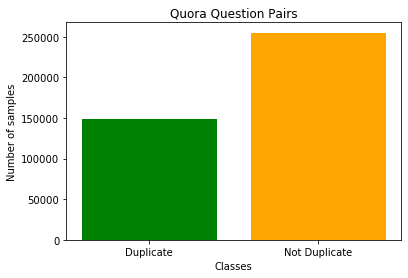

In [23]:
# Plotting the dataset as a bar chart

height = [len(dataset[dataset['is_duplicate'] == 1]), len(dataset[dataset['is_duplicate'] == 0])] 
tick_label = ['Duplicate', 'Not Duplicate']  
pos = [1, 2]
plt.bar(pos, height, tick_label = tick_label, 
        width = 0.8, color = ['green', 'orange']) 

plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Quora Question Pairs') 
 
plt.show() 

In [22]:
# get the samples with target ones and zeroes and balancing the dataset by pruning the samples with zeroes
zeroes = dataset[dataset['is_duplicate'] == 0].sample(149263, random_state=72)
ones = dataset[dataset['is_duplicate'] == 1]

In [5]:
# getting the balanced dataset
balanced_data = pd.concat([zeroes, ones], ignore_index=True).sample(frac=1, random_state=72)
balanced_data

,id,qid1,qid2,question1,question2,is_duplicate
298210,403311,536881,536882,What is partial factor of safety?,What are partial safety factors?,1
289328,377401,508693,67258,Is there a permanent remedial for chronic asthma?,Where can I find a permanent treatment for ast...,1
87567,81812,138845,138846,"How is Satyabama university, Chennai for B.Tec...","Which is better, a BSC or B.Tech in biotechnol...",0
29482,309929,247824,167878,How can I write an article for children?,What is the easiest way to write an article?,0
255446,285770,184478,163317,Who is the super master astrologer?,Who is the real super astrologer?,1
...,...,...,...,...,...,...
113871,157984,246884,751,What is the best courses for an MS in Germany ...,Which are the best universities in Germany for...,0
199493,134905,179672,119942,What company provides the best SEO services in...,Which is the best SEO services company in India?,1
216933,181955,278612,278613,What is the best way to make our parents feel ...,How can I make my parents proud?,1
70702,99575,165290,165291,"What is the difference between, Vadakalai and ...",What's the difference between Eastern Orthodox...,0


In [6]:
# get the X (question1 and question2) and y (is_duplicate)
X = balanced_data.iloc[:,3:5].values
y = balanced_data.iloc[:, 5].values

In [33]:
from sklearn.model_selection import train_test_split

In [7]:
# split data into training, validation and testing
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.33)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.7)

## Feature Engineering
To convert the text pairs into suitable embeddings for the neural network, the pretrained Universal Sentence Encoder is used to get fixed length embeddings of the text

In [38]:
# load the Universal Sentence Encoder from tensorflow hub
if os.path.isdir('4'):
    print('Loading from Local Directory...')
    encoder = hub.load('4')
    print('Done')
else:
    print('Downloading model...')
    encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
    print('Done')

Loading from Local Directory...
Done


In [11]:
def encode(dataset):
    """Returns the encoded array of the text dataset
    Args:
        dataset (array): the array containing the pairs of sentences

    Returns:
        encoded (numpy array): the numpy array containing the encoded text
    """
    encoded = []
    for x in tqdm(dataset):
        try:
            enc = encoder(x).numpy()
            encoded.append([enc])
        except:
            pass
    return np.concatenate(encoded)

In [ ]:
# Encode the data
X_train_enc = encode(X_train)

In [ ]:
X_val_enc = encode(X_val)

In [ ]:
X_test_enc = encode(X_test)

In [15]:
# Save the numpy arrays to .npy files as encoding all the text data takes more than one hour

# np.save('data/X_train_enc', X_train_enc)
# np.save('data/X_test_enc', X_test_enc)
# np.save('data/X_val_enc', X_val_enc)

# np.save('data/y_train', y_train)
# np.save('data/y_test', y_test)
# np.save('data/y_val', y_val)

In [16]:
# load the saved numpy arrays

X_train_enc = np.load('data/X_train_enc.npy')
X_test_enc = np.load('data/X_test_enc.npy')
X_val_enc = np.load('data/X_val_enc.npy')

y_train = np.load('data/y_train.npy')
y_val = np.load('data/y_val.npy')
y_test = np.load('data/y_test.npy')

## Building the model
The architecture of the model is as follows

![model](net.png "Model Architecture")

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, concatenate, Input

In [9]:
def create_model():
    """Returns the model"""
    input_1 = Input(shape=(512,))
    dense_1 = Dense(256, activation='relu')(input_1)

    input_2 = Input(shape=(512,))
    dense_2 = Dense(256, activation='relu')(input_2)

    concat = concatenate([dense_1, dense_2])
    x = Dense(256, activation='relu')(concat)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[input_1, input_2], outputs=outputs, name='SemanticNet')
    return model

In [10]:
# build the model
model = create_model()

In [11]:
model.summary()

Model: "SemanticNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          131328      input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          131328      input_4[0][0]                    
________________________________________________________________________________________

## Training

In [51]:
# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [5]:
# setup tensorboard callback
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [6]:
# setup early stopping
early_stop = tf.keras.callbacks.EarlyStopping(min_delta=0.02, patience=3)

In [56]:
history = model.fit([X_train_enc[:,0], X_train_enc[:,1]], y_train, 
                    validation_data=([X_val_enc[:,0], X_val_enc[:,1]], y_val), 
                    epochs=20, 
                    callbacks=[tensorboard_callback, early_stop])

Train on 200012 samples, validate on 89557 samples
Epoch 1/20
200012/200012 [==============================] - 37s 187us/sample - loss: 0.5154 - acc: 0.7422 - val_loss: 0.4530 - val_acc: 0.7832
Epoch 2/20
200012/200012 [==============================] - 36s 179us/sample - loss: 0.4555 - acc: 0.7870 - val_loss: 0.4643 - val_acc: 0.7910
Epoch 3/20
200012/200012 [==============================] - 35s 176us/sample - loss: 0.4270 - acc: 0.8064 - val_loss: 0.4701 - val_acc: 0.7766
Epoch 4/20
200012/200012 [==============================] - 32s 162us/sample - loss: 0.3996 - acc: 0.8222 - val_loss: 0.5148 - val_acc: 0.7950
Epoch 5/20
200012/200012 [==============================] - 37s 186us/sample - loss: 0.3810 - acc: 0.8360 - val_loss: 0.3942 - val_acc: 0.8323
Epoch 6/20
200012/200012 [==============================] - 40s 202us/sample - loss: 0.3658 - acc: 0.8448 - val_loss: 0.3702 - val_acc: 0.8461
Epoch 7/20
200012/200012 [==============================] - 35s 175us/sample - loss: 0.3467

In [74]:
# save the model weights
model.save_weights('model/sem_net_weights.h5')

# save the full model (backup)
model.save('model/sem_net_full.h5')

## Evaluate

In [12]:
# load the model weights
model.load_weights('model/sem_net_weights.h5')

In [13]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [39]:
def evaluate(X_test, y_test):
    """Evaluates and prints the Evaluation Results (Accuracy, Precision, Recall, F1)"""
    y_pred = model.predict([X_test[:,0], X_test[:,1]])
    y_pred = np.round(y_pred)
    
    accuracy = accuracy_score(y_test, y_pred)
    results = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print('Acccuracy:', accuracy)
    print('Precision:', results[0])
    print('Recall:', results[1])
    print('F1 Score:', results[2])

In [17]:
# evaluate the model against test data
evaluate(X_test_enc, y_test)

Acccuracy: 0.8853801281529796
Precision: 0.8507611026834755
Recall: 0.9345515141067632
F1 Score: 0.8906900328587076


In [40]:
def predict(text_1, text_2, model, encoder):
    """Returns the binary prediction or two strings of texts
    Args:
        text_1 (str): text A
        text_2 (str): text B
        
    Returns:
        pred (float): prediction value in range 0-1
    """    
    # get the emebeddings
    embeddings = encoder([text_1, text_2])
    embeddings = np.expand_dims(embeddings, axis=0)
    
    # make predictions
    pred = model.predict([embeddings[:,0], embeddings[:,1]])
    return float(pred)

In [30]:
# sample pieces of text
text_1 = """The woman cried out for help because a snake had trespassed into her house."""
text_2 = """The old woman was happy because she got a precious pearl necklace."""
text_3 = """The lady was happy as she got a necklace"""

In [29]:
# checking similarity between text_1 and text_3
predict(text_1, text_3, model, encoder)

0.001013148226775229

In [31]:
# checking similarity between text_2 and text_3
predict(text_2, text_3, model, encoder)

1.0